### A tutorial about simulating lightcurves observed by LSST. ###

Here I'll just grab a single point in the sky and look at what some possible light curves could look like. This could be handy if one wanted to test and refine some algorithms for deciding how good a light curve is.

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
outDir ='LightCurve'
dbFile = 'astro-lsst-01_2022.db'
opsimdb = db.OpsimDatabase(dbFile)
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
filters = ['u','g','r','i','z','y']
colors={'u': 'cyan','g': 'g','r': 'y',
        'i': 'r','z': 'm', 'y': 'k'}

**Parameters to set**

In [4]:
# Set RA, Dec for a single point in the sky.
# The input ra/dec values should be in DEGREES (even for v3 databases). 
ra = [0.0]
dec = [-10.0]
# SNR limit (Don't use points below this limit)
snrLimit = 5.
# Demand this many points above SNR limit before plotting LC
nPtsLimit = 6

In [5]:
# While we're in transition between opsim v3 and v4, this may be helpful:
print("{dbFile} is an opsim version {version} database".format(dbFile=dbFile, version=opsimdb.opsimVersion))
if opsimdb.opsimVersion == "V3":
    # For v3 databases:
    mjdcol = 'expMJD'
    degrees = False
else:
    # For v4 and alternate scheduler databases.
    mjdcol = 'observationStartMJD'
    degrees = True
# Note that astro-lsst-01_2022.db is a v4 database.

astro-lsst-01_2022.db is an opsim version V4 database


In [6]:
# The pass metric just passes data straight through.
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', mjdcol])
slicer = slicers.UserPointsSlicer(ra, dec, lonCol='fieldRA', latCol='fieldDec', latLonDeg=degrees)
sql = '' #'night < 365'
bundle = metricBundles.MetricBundle(metric,slicer,sql)
# In case you are using a dither stacker, we can check what columns are actually being pulled from the database.
print(bundle.dbCols)

{'fieldRA', 'filter', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth'}


In [7]:
bg = metricBundles.MetricBundleGroup({0: bundle}, opsimdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth'].
Found 2372700 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
# Let's see what the "pass" metric provided, looking at the first slicepoint (i.e. our ra/dec value).
print(bundle.metricValues.data[0].dtype.names)
# And look at some of the values.
print(bundle.metricValues.data[0][0:10])
# Another way to access just the filter information..
print(bundle.metricValues.data[0]['filter'][0:10])

('fieldRA', 'filter', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth')
[( 358.461683, 'i',  61316.1790625 , -9.933729,  23.54152911)
 ( 358.461683, 'r',  62394.23177083, -9.933729,  24.1176635 )
 ( 358.461683, 'y',  60601.0749537 , -9.933729,  21.89880558)
 ( 358.461683, 'z',  63198.03789352, -9.933729,  22.72590529)
 ( 358.461683, 'r',  61371.03956019, -9.933729,  24.25806062)
 ( 358.461683, 'z',  61277.26858796, -9.933729,  22.74012006)
 ( 358.461683, 'i',  63489.15615741, -9.933729,  23.68657595)
 ( 358.461683, 'y',  60574.15356481, -9.933729,  22.3228002 )
 ( 358.461683, 'z',  61369.03109954, -9.933729,  22.63080107)
 ( 358.461683, 'i',  61727.06900463, -9.933729,  23.47392021)]
['i' 'r' 'y' 'z' 'r' 'z' 'i' 'y' 'z' 'i']


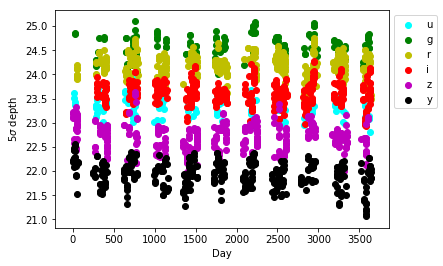

In [9]:
# Let's plot the time and m5 depth of these visits.
dayZero = bundle.metricValues.data[0][mjdcol].min()
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    plt.scatter(bundle.metricValues.data[0][mjdcol][good]- dayZero, 
                bundle.metricValues.data[0]['fiveSigmaDepth'][good],
                c = colors[fname], label=fname)
plt.xlabel('Day')
plt.ylabel('5$\sigma$ depth')
plt.legend(scatterpoints=1, loc="upper left", bbox_to_anchor=(1,1))

In [12]:
# Count up observations per filter.
print('%i Observations total at this point (All SNR levels)' % bundle.metricValues.data[0].size)
for fname in filters:
    good = np.where(bundle.metricValues.data[0]['filter'] == fname)
    print('%i Observations in %s' % (good[0].size, fname))

1723 Observations total at this point (All SNR levels)
118 Observations in u
165 Observations in g
374 Observations in r
381 Observations in i
343 Observations in z
342 Observations in y


In [13]:
# Let's test out a metric from MAF (the TransientMetric) on this bit of data. 
data = bundle.metricValues.data[0]
peakTime = 15
transDuration = peakTime+30 # Days
peaks = {'uPeak':25.9, 'gPeak':23.6, 'rPeak':22.6, 'iPeak':22.7, 'zPeak':22.7,'yPeak':22.8}
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30.0, 
                                      transDuration=transDuration, peakTime=peakTime, 
                                      surveyDuration=10, mjdCol=mjdcol, **peaks)
lc = transMetric.lightCurve((data[mjdcol]-dayZero) % transDuration, data['filter'])
snr = utils.m52snr(lc,data['fiveSigmaDepth'])
lc_err = 2.5*np.log10(1.+1./snr)

/Users/lynnej/lsstsw2/miniconda/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fraction of LCs that meet criteria and plotted = 35/81


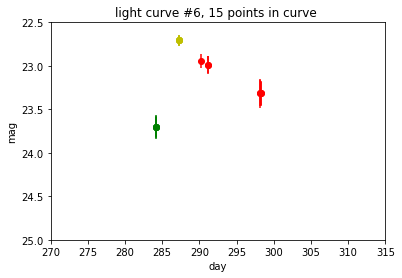

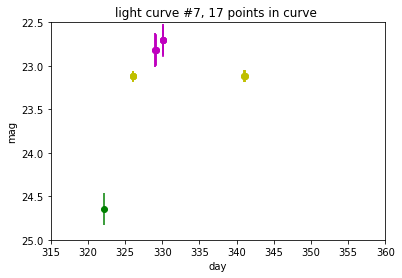

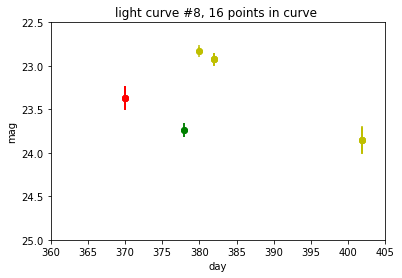

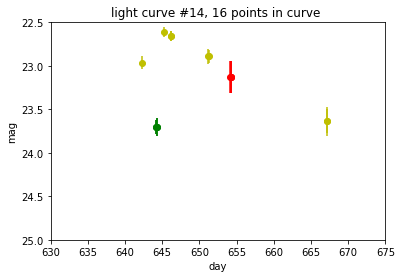

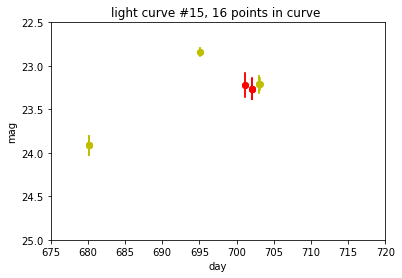

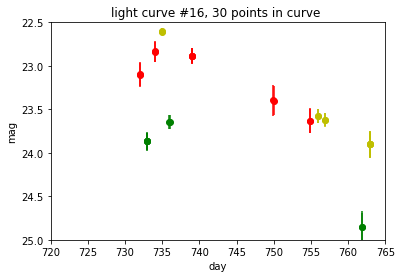

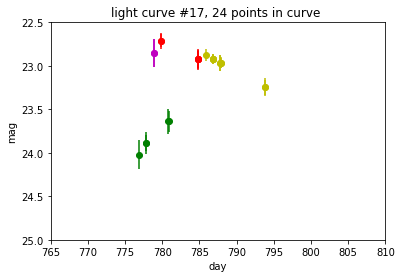

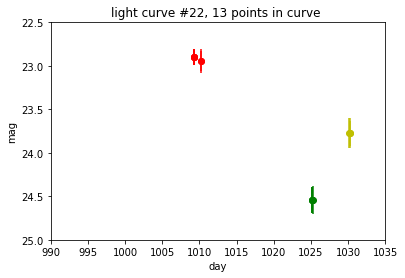

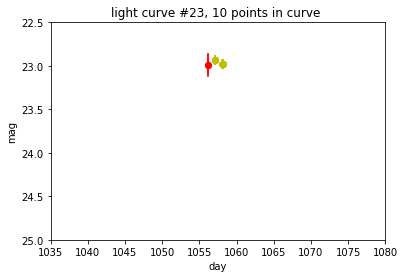

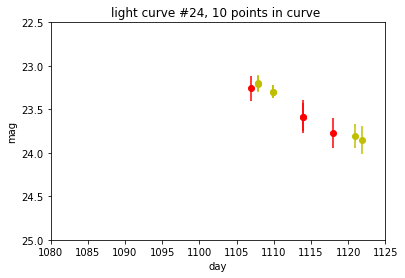

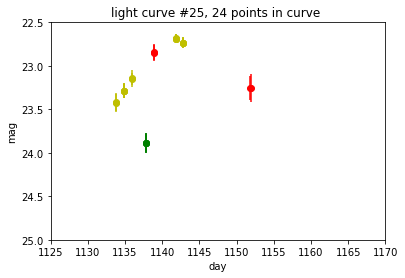

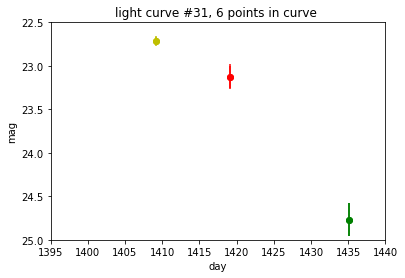

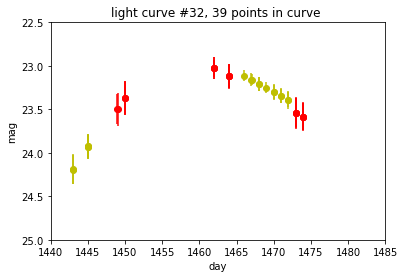

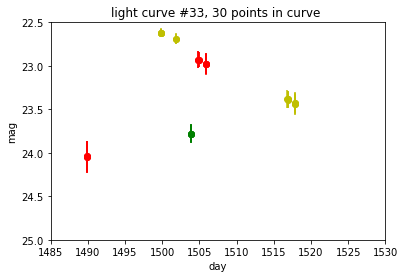

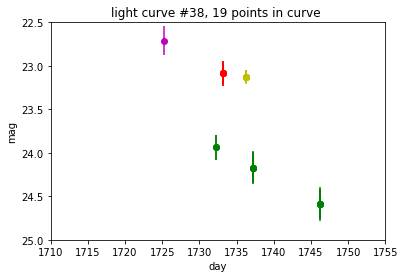

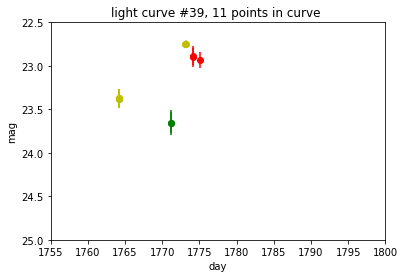

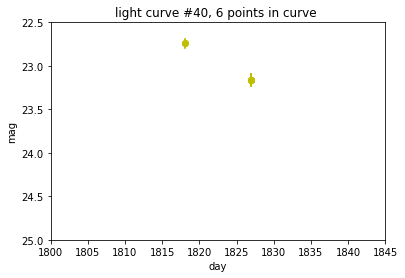

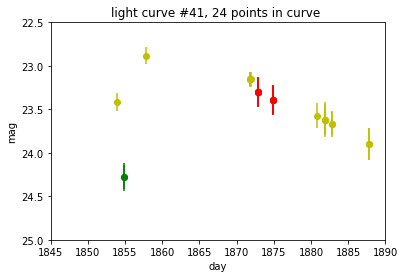

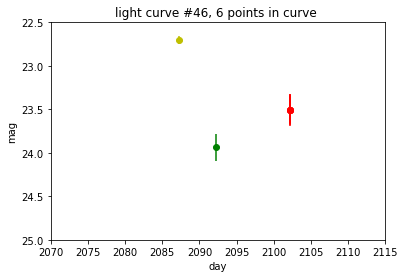

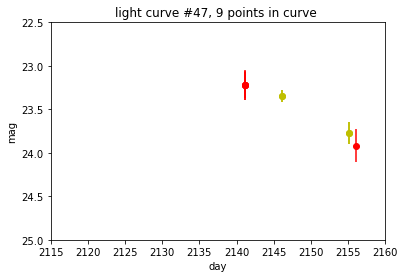

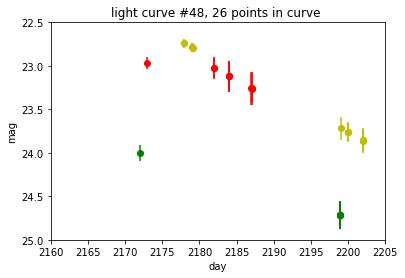

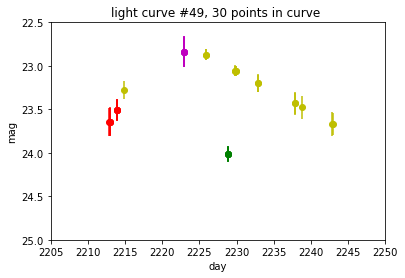

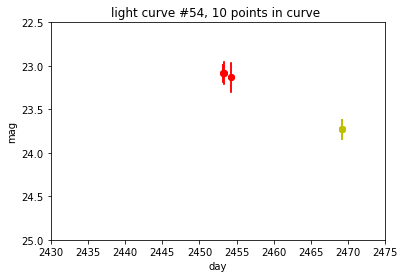

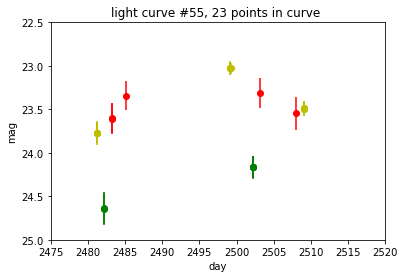

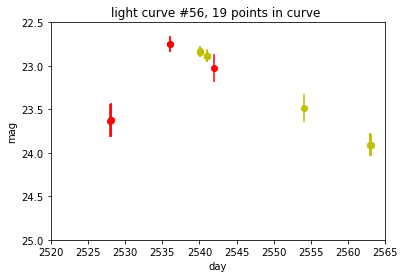

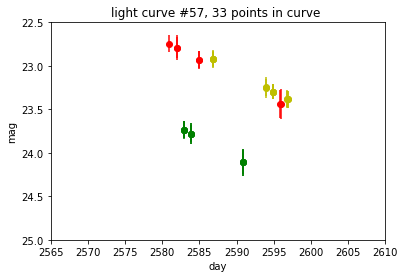

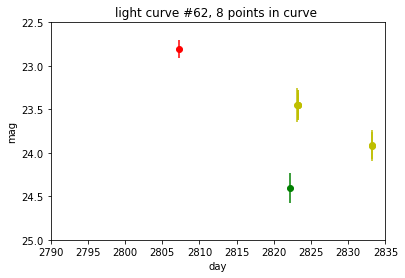

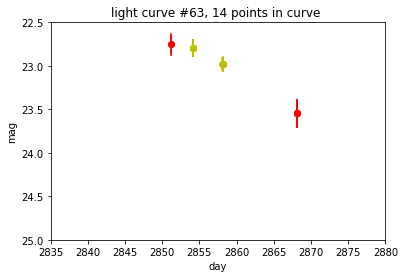

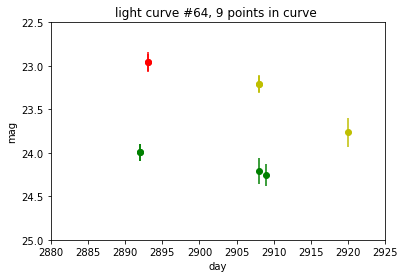

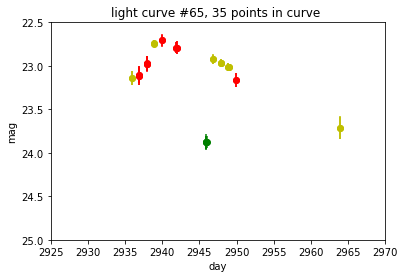

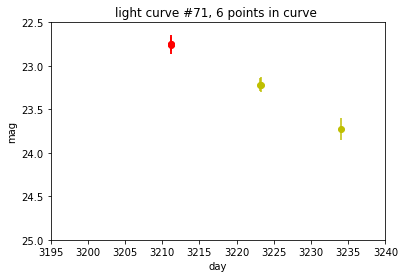

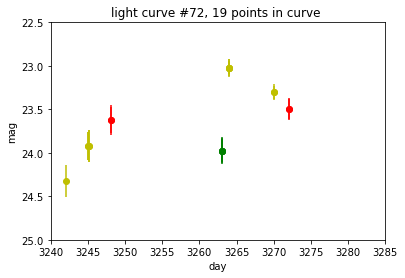

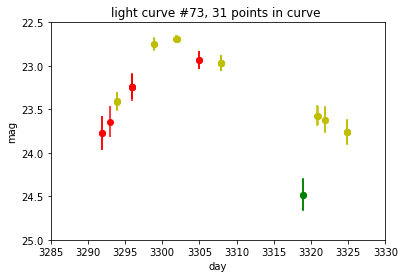

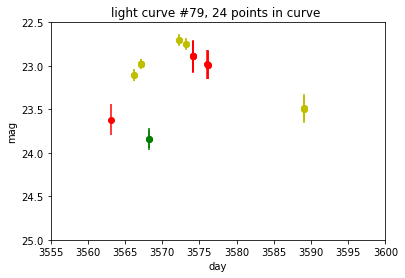

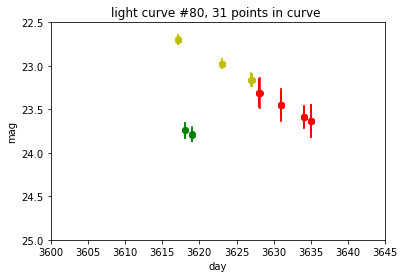

In [14]:
numOfLCs = np.ceil((data[mjdcol].max()-data[mjdcol].min())/transDuration)
plotCounter = 0
outputToASCII = True

for lcn in np.arange(0,numOfLCs+1,1):
    good = np.where(( data[mjdcol] >= data[mjdcol].min()+transDuration*lcn)
                       & ( data[mjdcol] <= data[mjdcol].min()+transDuration*(1+lcn))
                       & (snr > snrLimit))
    if good[0].size >= nPtsLimit:
        if outputToASCII:
            outfile = open('lc_%i.dat' % lcn, 'w')
            outfile.write('MJD  filter  mag  magErr')
            for i,mag in enumerate(data[mjdcol][good]):
                outfile.write('%f  %s  %f  %f' % (data[mjdcol][good][i], data['filter'][good][i], 
                                                  lc[good][i], lc_err[good][i]))
            outfile.close()
        plotCounter += 1
        plt.figure()
        # Counter
        numPoints = 0
        for filterName in filters:
            good = np.where((data['filter'] == filterName) & 
                            ( data[mjdcol] >= data[mjdcol].min()+transDuration*lcn)
                           & ( data[mjdcol] <= data[mjdcol].min()+transDuration*(1+lcn))
                           & (snr > snrLimit))
            plt.errorbar(data[mjdcol][good]-dayZero, lc[good], yerr=lc_err[good], 
                         c=colors[filterName], marker='o', linestyle='None')
            numPoints += good[0].size
        explodeDate=data[mjdcol].min()+transDuration*lcn
        plt.xlim([explodeDate-dayZero,explodeDate+transDuration-dayZero])
        plt.xlabel('day')
        plt.ylabel('mag')
        plt.title('light curve #%i, %i points in curve ' % (lcn, numPoints))
        plt.ylim([25., 22.5])
print('Fraction of LCs that meet criteria and plotted = %i/%i' % (plotCounter, numOfLCs))

Let's do it for something really bright, just to see all the points in the light curves

In [15]:
data = bundle.metricValues.data[0]
peakTime = 15
transDuration = peakTime+30 # Days
peaks = {'uPeak':20, 'gPeak':20, 'rPeak':20, 'iPeak':20, 'zPeak':20,'yPeak':20}
transMetric = metrics.TransientMetric(riseSlope= 0, declineSlope=0, 
                                      transDuration=transDuration, peakTime=peakTime, 
                                      surveyDuration=10, **peaks)
lc = transMetric.lightCurve((data[mjdcol]-dayZero) % transDuration, data['filter'])
snr = utils.m52snr(lc,data['fiveSigmaDepth'])
lc_err = 2.5*np.log10(1.+1./snr)

/Users/lynnej/lsstsw2/miniconda/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fraction of LCs that meet criteria and plotted = 46/81


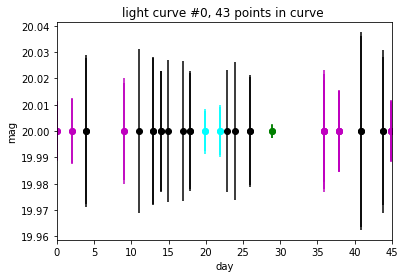

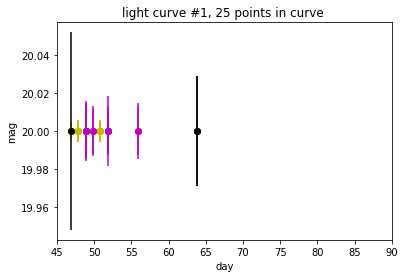

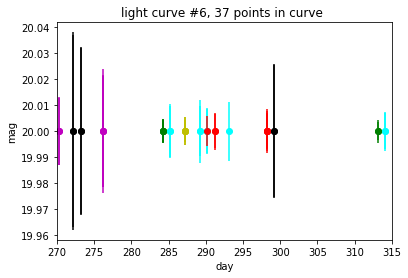

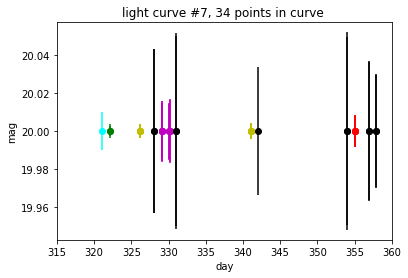

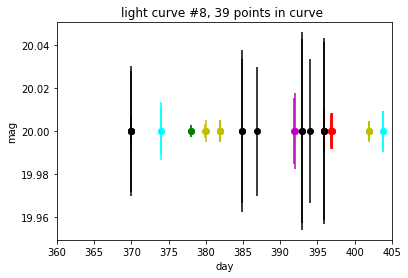

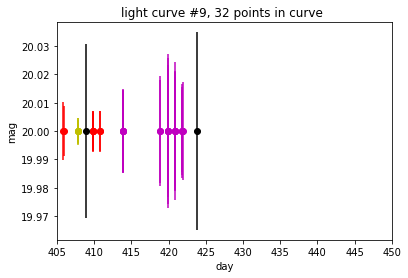

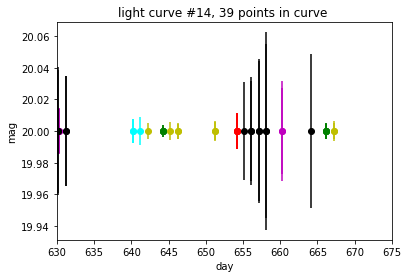

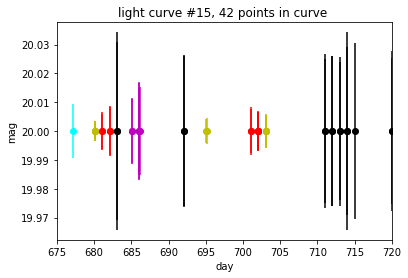

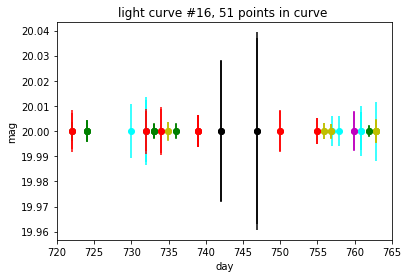

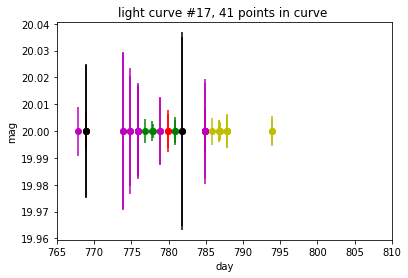

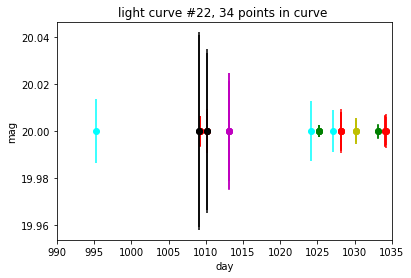

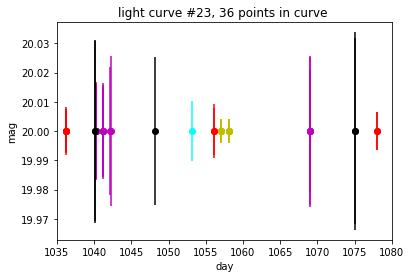

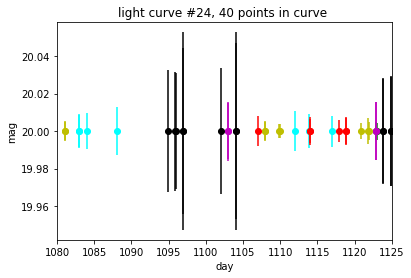

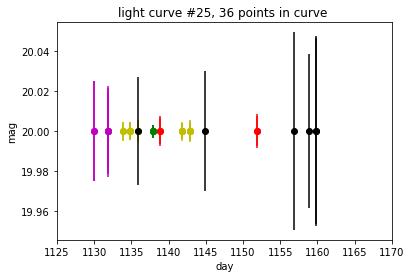

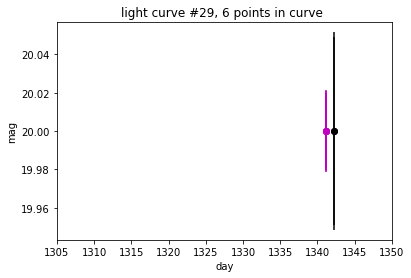

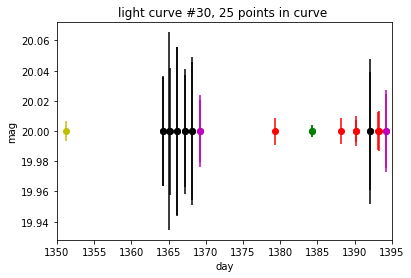

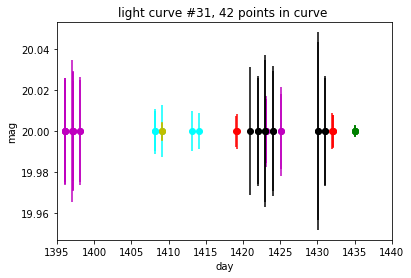

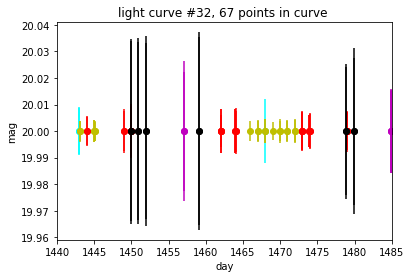

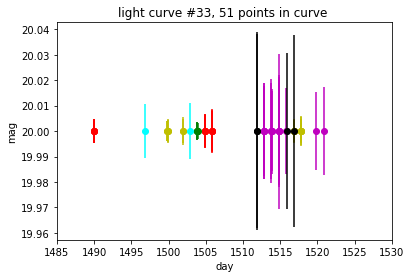

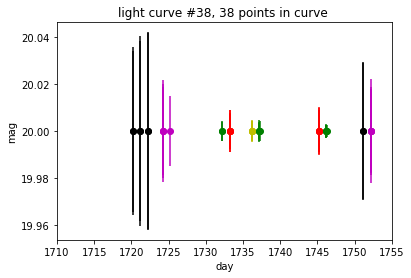

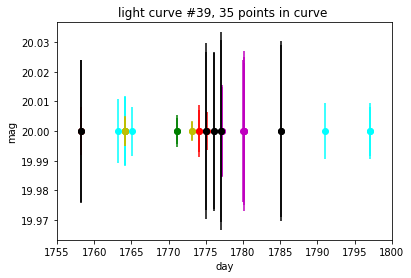

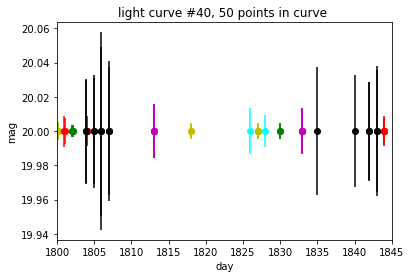

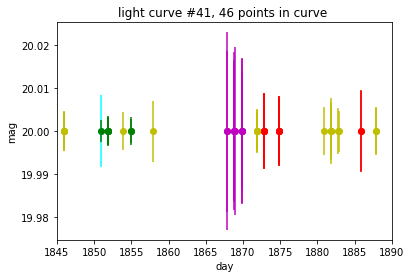

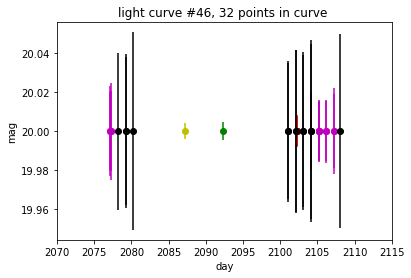

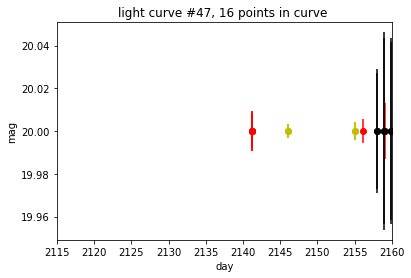

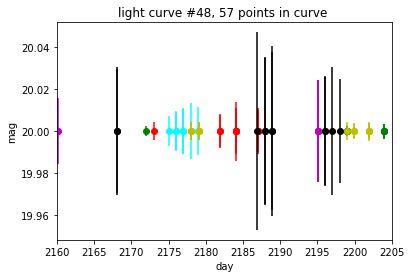

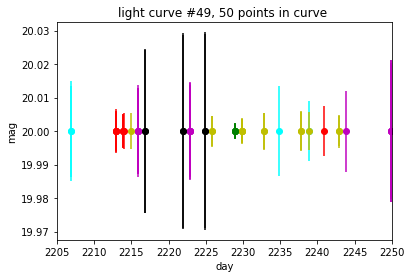

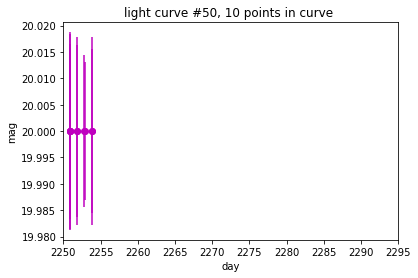

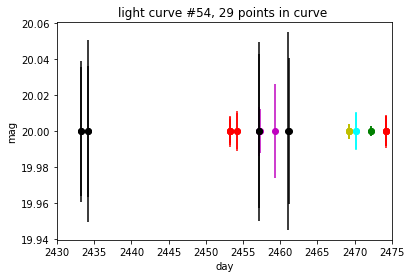

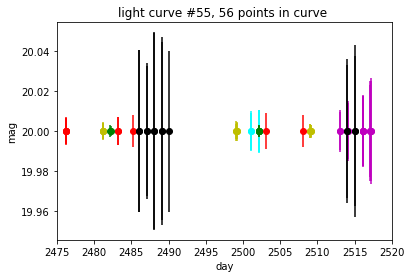

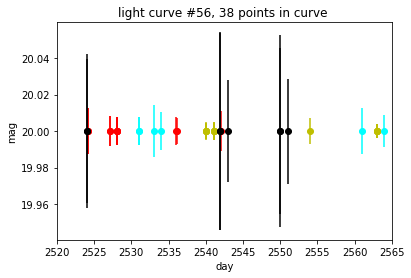

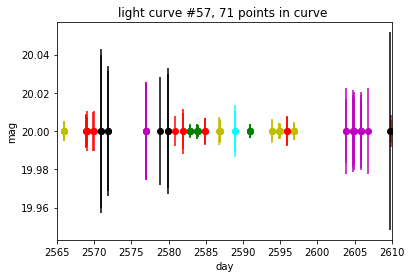

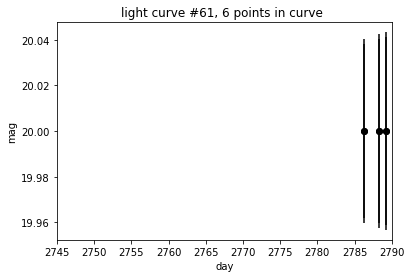

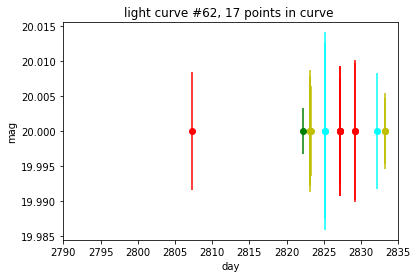

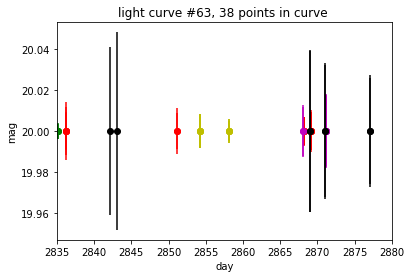

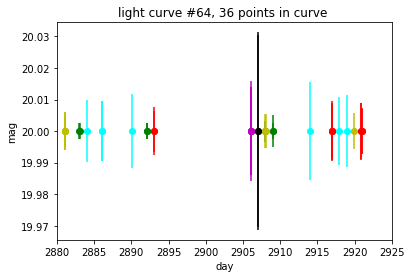

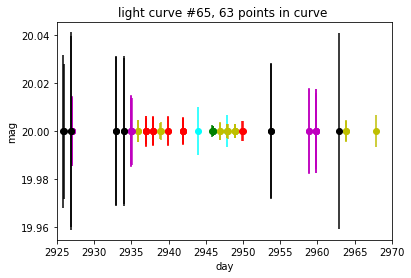

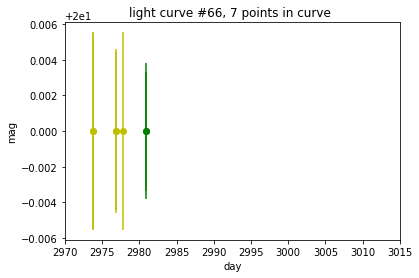

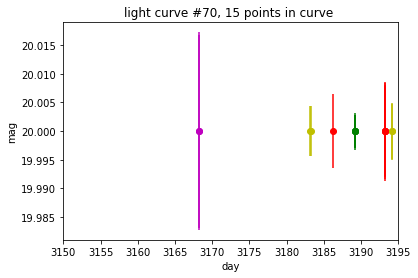

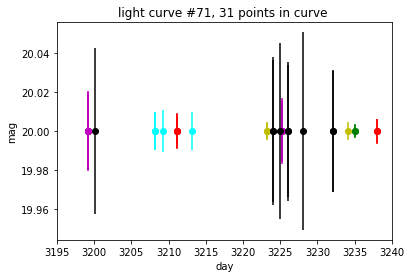

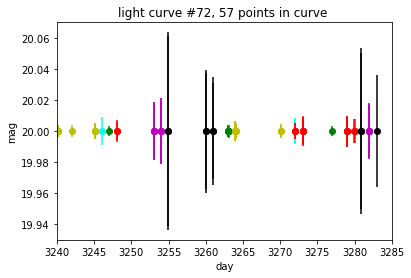

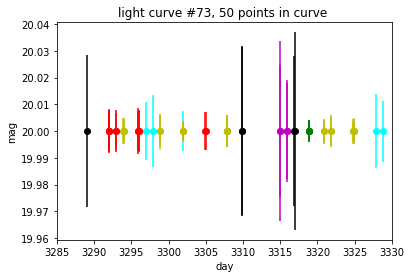

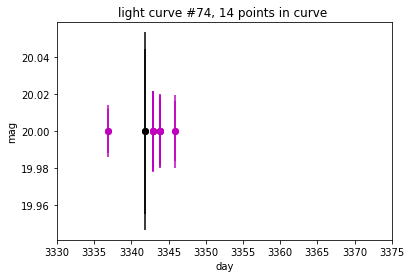

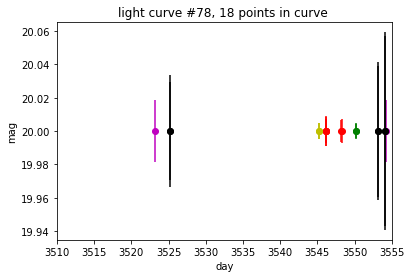

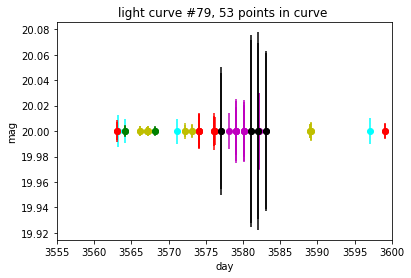

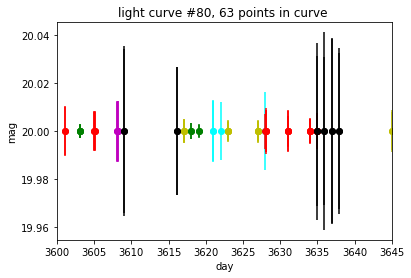

In [16]:
numOfLCs = np.ceil((data[mjdcol].max()-data[mjdcol].min())/transDuration)
plotCounter = 0
for lcn in np.arange(0,numOfLCs+1,1):
    good = np.where(( data[mjdcol] >= data[mjdcol].min()+transDuration*lcn)
                       & ( data[mjdcol] <= data[mjdcol].min()+transDuration*(1+lcn))
                       & (snr > snrLimit))
    if good[0].size >= nPtsLimit:
        plotCounter += 1
        plt.figure()
        # Counter
        numPoints = 0
        for filterName in filters:
            good = np.where((data['filter'] == filterName) & 
                            ( data[mjdcol] >= data[mjdcol].min()+transDuration*lcn)
                           & ( data[mjdcol] <= data[mjdcol].min()+transDuration*(1+lcn))
                           & (snr > snrLimit))
            plt.errorbar(data[mjdcol][good]-dayZero, lc[good], yerr=lc_err[good], 
                         c=colors[filterName], marker='o', linestyle='None')
            numPoints += good[0].size
        explodeDate=data[mjdcol].min()+transDuration*lcn
        plt.xlim([explodeDate-dayZero,explodeDate+transDuration-dayZero])
        plt.xlabel('day')
        plt.ylabel('mag')
        plt.title('light curve #%i, %i points in curve ' % (lcn, numPoints))
        
print('Fraction of LCs that meet criteria and plotted = %i/%i' % (plotCounter, numOfLCs))